In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function
import numpy as np

import matplotlib.pyplot as plt
import pyvista as pv
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import h5py   

In [2]:
u = uw.scaling.units
ndim = uw.scaling.non_dimensionalise
dim = uw.scaling.dimensionalise

# scaling 3: vel
H = 3000.  * u.kilometer
velocity     = 1e-9 * u.meter / u.second
#g    =   10.0 * u.meter / u.second**2  
#bodyforce    = 3300  * u.kilogram / u.metre**3 * g 
mu           = 1e21  * u.pascal * u.second

KL = H
Kt = KL / velocity
KM = mu * KL * Kt

scaling_coefficients                    = uw.scaling.get_coefficients()
scaling_coefficients["[length]"] = KL
scaling_coefficients["[time]"] = Kt
scaling_coefficients["[mass]"]= KM

In [3]:
D = ndim(3000*u.kilometer)
ratio = 4
wavelength = D/ratio
k = 2.0 * np.pi / wavelength
mu0 = ndim(1e21  * u.pascal * u.second)
g = ndim(10.0 * u.meter / u.second**2 )
rho0 = ndim(4500  * u.kilogram / u.metre**3)
drho = rho0
F0 = ndim(1*u.kilometer)

yres = 80 
xmin, xmax = 0, wavelength
ymin, ymax = -D, 0
boxl = xmax-xmin
boxh = ymax-ymin
xres = int(boxl/boxh*yres)

x0 = np.linspace(xmin,xmax,xres+1)
y0 = F0*np.cos(k*x0)

def perturbation(x):
    return F0 * np.cos(k*x)

In [4]:
### Anayltical solution

tau0 = 2*k*mu0/drho/g
# print(dim(tau0,u.kiloyear))
# print((ratio*4*np.pi*1e21/4500/3e6/10)/(365.25*24*60*60*1000))  #kiloyear

tmax = tau0*4

z = 0
x = x0

tau = (D*k+np.sinh(D*k)*np.cosh(D*k))/(np.sinh(D*k)**2)*tau0
A = -F0/k/tau0
B = -F0/k/tau
C = F0/tau
E = F0/tau/np.tanh(D*k)
phi = np.sin(k*x)*np.exp(-tmax/tau)*(A*np.sinh(k*z)+B*np.cosh(k*z)+C*z*np.sinh(k*z)+E*z*np.cosh(k*z))

F = F0*np.exp(-tmax/tau)
y = F*np.cos(k*x)


t_relax = tau0
F_relax = F0*np.exp(-t_relax/tau)
y_relax = F_relax*np.cos(k*x)

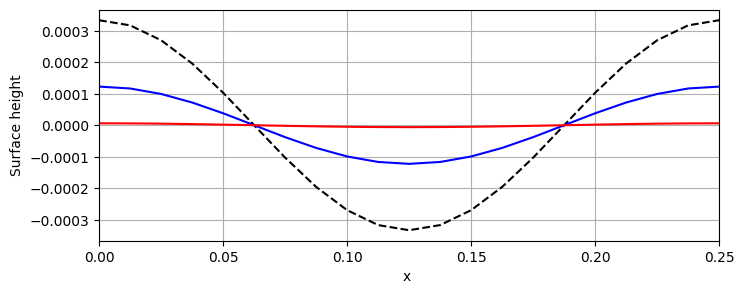

In [5]:
fname = f'The surface of final step'
fname_save = fname +".png"
fig,ax1 = plt.subplots(1, 1, figsize=(8,3))
ax1.set(xlabel='x ', ylabel='Surface height') 
ax1.plot(x0,y0,'--k',label="initial surface")
ax1.plot(x0,y_relax,c='b',label="mid surface")
ax1.plot(x,y,c='r',label="final surface")
ax1.set_xlim([xmin,xmax])
ax1.grid()
plt.savefig(fname_save,dpi=150,bbox_inches='tight')

In [6]:
from underworld3.cython.petsc_discretisation import petsc_dm_find_labeled_points_local
from petsc4py import PETSc
comm = PETSc.COMM_WORLD

def load_mesh_topwall(fdir,load_step,save_name,scaling):
    filename = fdir + f'{save_name}{load_step:05d}.h5'
    viewer = PETSc.ViewerHDF5().create(filename, "r", comm=comm)
    h5plex = PETSc.DMPlex().create(comm=comm)
    sf0 = h5plex.topologyLoad(viewer)
    h5plex.coordinatesLoad(viewer, sf0)
    h5plex.labelsLoad(viewer, sf0)
    
    cdim = 2
    dm = h5plex
    topwall = petsc_dm_find_labeled_points_local(dm,"Top")
    coord_vec = dm.getCoordinatesLocal()
    coords = coord_vec.array.reshape(-1, cdim)
    
    return coords[topwall]*scaling

In [7]:
def L2_norm(a,b):
    return np.sqrt(np.sum(np.square(a-b)))

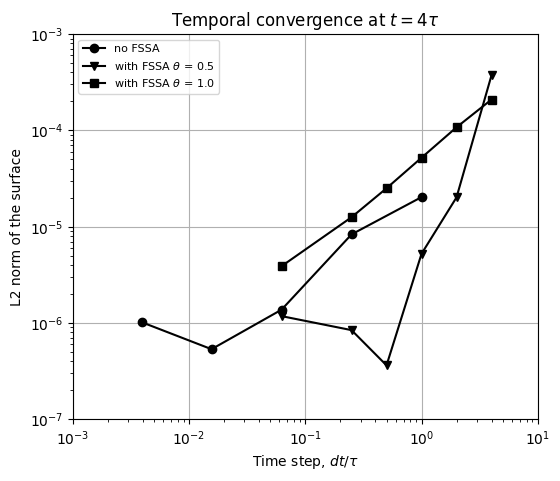

In [10]:
Timestep = []
Error = []
for i in range(5): 
    timeratio = (1/4)**int(i)
    dt_set    = tau0*timeratio
    max_time  = tmax 
    fdir = "op_2DRelaxation_FreeSurf" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)

#     load_step =int(tau0/dt_set)
#     coords = load_mesh_topwall(fdir,load_step,'_step_',1.)
#     yy = coords[:,1][np.argsort(coords[:,0])]
#     error = L2_norm(yy,y_relax)
     
    load_step =int(tau0*4/dt_set)
    coords = load_mesh_topwall(fdir,load_step,'_step_',1.)
    yy = coords[:,1][np.argsort(coords[:,0])]
    error = L2_norm(yy,y)
    
    Timestep.append((1/4)**i)
    Error.append(error)

    
Timestep0 = []
Error0 = []
ratiorange = [4,2,1,0,-1,-2]
for i in ratiorange: 
    timeratio = (1/2)**int(i)
    dt_set    = tau0*timeratio
    max_time  = tmax 
    fdir = "op_2DRelaxation_FreeSurf_FSSA0.5" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)

    load_step =int(tau0*4/dt_set)
    coords = load_mesh_topwall(fdir,load_step,'_step_',1.)
    yy = coords[:,1][np.argsort(coords[:,0])]
    error = L2_norm(yy,y)
    
    Timestep0.append((1/2)**i)
    Error0.append(error)    
    
Timestep1 = []
Error1 = []
ratiorange = [4,2,1,0,-1,-2]
for i in ratiorange: 
    timeratio = (1/2)**int(i)
    dt_set    = tau0*timeratio
    max_time  = tmax 
    fdir = "op_2DRelaxation_FreeSurf_FSSA1" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)

    load_step =int(tau0*4/dt_set)
    coords = load_mesh_topwall(fdir,load_step,'_step_',1.)
    yy = coords[:,1][np.argsort(coords[:,0])]
    error = L2_norm(yy,y)
    
    Timestep1.append((1/2)**i)
    Error1.append(error)  

fname = r"Temporal convergence at $t = 4\tau$"
fig, ax1 = plt.subplots(nrows=1, figsize=(6,5))
plt.xscale('log')
plt.yscale('log')
ax1.set(xlabel=r'Time step, $dt/\tau$', ylabel='L2 norm of the surface') 
ax1.set_title(fname)
ax1.plot(Timestep,Error,'-ok',label="no FSSA")
ax1.plot(Timestep0,Error0,'-vk',label=r"with FSSA $\theta$ = 0.5")
ax1.plot(Timestep1,Error1,'-sk',label=r"with FSSA $\theta$ = 1.0")
ax1.grid()
ax1.legend(loc = 'upper left',prop = {'size':8})
ax1.set_ylim([1e-7,1e-3])
ax1.set_xlim([1e-3,1e1])
#plt.xscale('log')
#plt.yscale('log')
plt.savefig(fname+'.png',dpi=150,bbox_inches='tight')

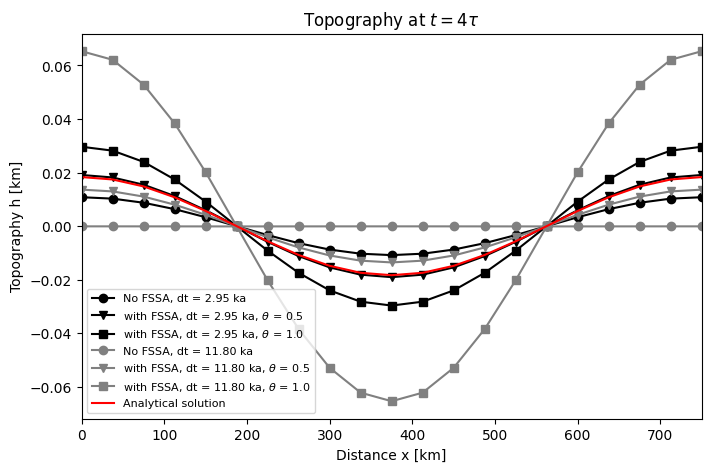

In [11]:
fname = r"Topography at $t = 4\tau$"
fig, ax1 = plt.subplots(nrows=1, figsize=(8,5))
ax1.set(xlabel= 'Distance x [km]', ylabel='Topography h [km]')

timeratios = [1/4,1]
colors = ['black','grey']
linestyles=['solid','solid'] #'dotted']

linestyle=linestyles[i]
for i,timeratio in enumerate(timeratios):
    #timeratio = (1/4)**int(i)
    dt_set    = tau0*timeratio
    max_time  = tmax 
    fdir = "op_2DRelaxation_FreeSurf" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)

    load_step = int(tau0*4/dt_set)
    coords = load_mesh_topwall(fdir,load_step,'_step_',KL.m)
    yy = coords[:,1][np.argsort(coords[:,0])]
    ax1.plot(x*KL.m,yy,color = colors[i],linestyle=linestyles[i],marker='o',label= 'No FSSA, dt = {:.2f} ka'.format(dim(dt_set,u.kiloyear).m))
    
    fdir = "op_2DRelaxation_FreeSurf_FSSA0.5" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)
    coords = load_mesh_topwall(fdir,load_step,'_step_',KL.m)
    yy = coords[:,1][np.argsort(coords[:,0])]
    ax1.plot(x*KL.m,yy,color = colors[i],linestyle=linestyles[i],marker='v',label= r'with FSSA, dt = {:.2f} ka, $\theta$ = 0.5'.format(dim(dt_set,u.kiloyear).m))
    

    fdir = "op_2DRelaxation_FreeSurf_FSSA1" + "_yres{:n}_dt{:.2f}ka_Tmax{:.1f}ka/".format(yres,dim(dt_set,u.kiloyear).m,dim(max_time,u.kiloyear).m)
    coords = load_mesh_topwall(fdir,load_step,'_step_',KL.m)
    yy = coords[:,1][np.argsort(coords[:,0])]
    ax1.plot(x*KL.m,yy,color = colors[i],linestyle=linestyles[i],marker='s',label= r'with FSSA, dt = {:.2f} ka, $\theta$ = 1.0'.format(dim(dt_set,u.kiloyear).m))

#ax1.plot(x0*KL.m,y_relax*KL.m,'--k',label= 'Analytical solution')
ax1.plot(x0*KL.m,y*KL.m,'-r',label= 'Analytical solution')
ax1.set_xlim([xmin*KL.m,xmax*KL.m])
ax1.set_title(fname)
#ax1.grid()
ax1.legend(loc = 'lower left',prop = {'size':8})
#plt.xscale('log')
#plt.yscale('log')
plt.savefig(fname+'.png',dpi=150,bbox_inches='tight')